# Conformer generation for small molecules

## Background ##
### Algorithm ###

Given a list of $N$ dihedral angles (torsions) `dihedrals`

1. generate all conformers by rotating all torsions in increments $\delta\phi$ for a total of $(2\pi/\delta\phi)^N$ conformers (cartesian product)
2. write to a trajectory

### Implementation notes ###

1. Load molecules with MDAnalysis.
2. Convert to RDKit molecule.
3. Perform torsion drive with [rdkit.Chem.rdMolTransforms](https://www.rdkit.org/docs/source/rdkit.Chem.rdMolTransforms.html)

```
rdkit.Chem.rdMolTransforms.SetDihedralDeg((Conformer)arg1, (int)arg2, (int)arg3, (int)arg4, (int)arg5, (float)arg6) → None :

    Sets the dihedral angle in degrees between atoms i, j, k, l; all atoms bonded to atom l are moved
```

### Initial test data ###
#### COW dataset ####

`/Users/oliver/Projects/Methods/SAMPL5/sampl5-distribution-water-cyclohexane/11_validation_dataset92`

- V36-methylacetate : 1 dihedral
- V46-2-methyl-1-nitrobenzene : steric hindrance
- V39-butylacetate : 4 dihedrals


## Setup
### Packages

In [145]:
import MDAnalysis as mda
import rdkit
import rdkit.Chem.rdMolTransforms
from rdkit.Chem.rdMolTransforms import SetDihedralDeg
import numpy as np

import pathlib
import itertools

In [4]:
print(mda.__version__)
print(rdkit.__version__)

2.5.0
2023.03.2


Nicer RDKit output in the notebook (larger labels)

In [60]:
import rdkit.Chem.Draw.IPythonConsole
rdkit.Chem.Draw.IPythonConsole.drawOptions.annotationFontScale = 0.8

### Data paths

In [21]:
COWDIR = pathlib.Path("../COW")
DATADIRS = {p.name[:3]: p for p in COWDIR.glob("V[0-9][0-9]-*")}

In [22]:
DATADIRS

{'V39': PosixPath('../COW/V39-butylacetate'),
 'V36': PosixPath('../COW/V36-methylacetate'),
 'V46': PosixPath('../COW/V46-2-methyl-1-nitrobenzene')}

## Packaged code

Production code is stored in `confgen.sampler` (subject to name change...).

In [302]:
import sys
sys.path.append("..")

In [307]:
import confgen
from confgen import sampler, chem

# during development
from importlib import reload
reload(sampler)
reload(chem)

<module 'confgen.chem' from '/Volumes/ASU/oliver/Projects/Methods/smallmol_conformers/notebooks/../confgen/chem.py'>

### Example

We will use the MDPOW input files for V36 and generate a trajectory that samples two torsions.

In [220]:
d

PosixPath('../COW/V36-methylacetate')

Use the convenience function `load_mdpow_mol()` (otherwise, use `load_mol(universe)`):

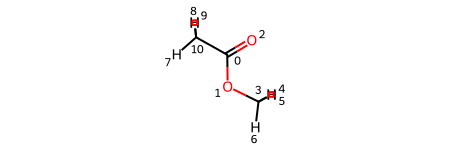

In [221]:
u, mol = sampler.load_mdpow_mol(d, add_labels=True)
mol

Set up dihedrals as MDAnalysis dihedral objects.

In [223]:
dihedrals = [u.atoms[[7, 10, 0, 1]].dihedral,
             u.atoms[[10, 0, 1, 3]].dihedral]

Run the sampler; this is very fast but note that the size of the in-memory trajectory grows exponentially with increasing samples and dihedrals.

In [233]:
samples = sampler.generate_conformers(mol, dihedrals, num=36)

  0%|          | 0/1296 [00:00<?, ?it/s]

The resulting `samples` universe can now be analyzed or we can just write the conformers to a trajectory in any format that MDAnalysis can write:

In [234]:
samples.atoms.write("conformers.trr", frames="all")

## Prototype

This section was used to *develop* the code. It shows step-by-step development.

**For production use, refer to the packaged code in `confgen.sampler`.**

In [62]:
d = DATADIRS['V36']

In [63]:
list(d.glob("*"))

[PosixPath('../COW/V36-methylacetate/V36-methylacetate.pdb'),
 PosixPath('../COW/V36-methylacetate/V36-methylacetate.itp'),
 PosixPath('../COW/V36-methylacetate/V36-methylacetate.mol2'),
 PosixPath('../COW/V36-methylacetate/V36-methylacetate.smi')]

We can't use the mol2 file because the ordering differs from the GROMACS files (PDB, TPR, trajectories). We therefore use the ITP as a minimal topology but need to guess the elements so that we can convert to RDKIT:

In [155]:
topol = list(d.glob("*.itp"))[0]
coords = list(d.glob("*.pdb"))[0]
u = mda.Universe(topol, coords)

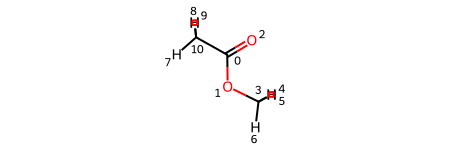

In [126]:
try:
    mol = u.atoms.convert_to("RDKIT")
except AttributeError:
    from MDAnalysis.topology.guessers import guess_types
    u.add_TopologyAttr('elements', guess_types(u.atoms.names))
    mol = u.atoms.convert_to("RDKIT")
for atom in mol.GetAtoms():
    atom.SetProp("atomNote", str(atom.GetIdx()))
mol

In [183]:
def load_mol(topdir, add_labels=False):
    """Load Universe and RDKIT mol from MDPOW directory.

    Parameters
    ----------
    topdir : pathlib.Path
        top directory containing ITP and PDB file
    add_labels : bool, optiona;
        add MDAnalysis atom index labels to the `mol`

    Returns
    -------
    universe : Universe
        MDAnalysis Universe data structure
    mol : rdkit.Chem.rdchem.Mol
        RDKit molecule object
    """
    
    topol = list(topdir.glob("*.itp"))[0]
    coords = list(topdir.glob("*.pdb"))[0]
    u = mda.Universe(topol, coords)

    try:
        mol = u.atoms.convert_to("RDKIT")
    except AttributeError:
        from MDAnalysis.topology.guessers import guess_types
        u.add_TopologyAttr('elements', guess_types(u.atoms.names))
        mol = u.atoms.convert_to("RDKIT")
    if add_labels:
        for atom in mol.GetAtoms():
            atom.SetProp("atomNote", str(atom.GetIdx()))
    
    return u, mol

### Single dihedral drive

Let's get a test dihedral angle: C10-C0-O1-C3 (this should have cis/trans only)

In [127]:
dih = u.atoms[[10, 0, 1, 3]].dihedral
dih.value()

179.75436021525212

In [128]:
dih.atoms.indices

array([10,  0,  1,  3])

In [130]:
conformer = mol.GetConformer()

n_rot = 6
phi0 = dih.value()
phi_values = phi0 + np.linspace(0, 360, n_rot, endpoint=False)

n_frames = n_rot
trajectory = np.empty((n_frames, u.atoms.n_atoms, 3), dtype=np.float32)
for i_frame, phi in enumerate(phi_values):
    SetDihedralDeg(conformer, *dih.atoms.indices.tolist(), phi)
    trajectory[i_frame] = conformer.GetPositions()

Replace the original coordinates with the in-memory trajectory.

In [ ]:
u.load_new(trajectory)
u.atoms.write("torsion.trr", frames="all")

### Multiple dihedrals

Create the Cartesian product of all angles.

In [151]:
def anglespace(start, num, total=360.):
    """generate num-1 equally spaced angles in degree over the range total, starting at start"""
    return start + np.linspace(0, total, num, endpoint=False)

def dihedralangles(dihedral, num, **kwargs):
    phi0 = dihedral.value()
    return anglespace(phi0, num, **kwargs)

Collect all dihedrals:

In [193]:
u, mol = load_mol(d)

In [208]:
dih_1 = u.atoms[[10, 0, 1, 3]].dihedral
dih_2 = u.atoms[[7, 10, 0, 1]].dihedral
#dih_3 = u.atoms[[0, 1, 3, 6]].dihedral
dihedrals = [dih_2, dih_1] #, dih_3]

Compute the ranges for the dihedrals and keep in a list where the index corresponds to the dihedral in `dihedrals`:

In [209]:
num = 36
phi_ranges = [dihedralangles(d, num) for d in dihedrals]

Generate the Cartesian product for all ranges:

In [210]:
len(list(itertools.product(*phi_ranges)))

1296

In [211]:
n_frames = np.product([len(x) for x in phi_ranges])
n_frames

1296

In [212]:
trajectory = np.empty((n_frames, u.atoms.n_atoms, 3), dtype=np.float32)

In [213]:
conformer = mol.GetConformer()

for i_frame, phis in enumerate(itertools.product(*phi_ranges)):
    # set all dihedrals
    for dih, phi in zip(dihedrals, phis):
        SetDihedralDeg(conformer, *dih.atoms.indices.tolist(), phi)
    trajectory[i_frame] = conformer.GetPositions()

Replace the original coordinates with the in-memory trajectory.

In [214]:
u.load_new(trajectory)
u.atoms.write("torsion.trr", frames="all")

The trajectory rotates through the dihedrals as expected, as visualized in VMD.

### Automatic dihedral extraction

Based on Cade's code.

In [236]:
SMARTS = '[!#1]~[!$(*#*)&!D1]-!@[!$(*#*)&!D1]~[!#1]'
pattern = rdkit.Chem.MolFromSmarts(SMARTS)

In [237]:
atom_indices = mol.GetSubstructMatches(pattern)

In [238]:
atom_indices

((2, 0, 1, 3), (3, 1, 0, 10))

Note that this essentially the same torsion because it contains the central bond between 0 - 1.

We should find a way to remove those torsions.

Test dihedrals

In [286]:
dhs = np.array([(3, 1, 0, 10), (0, 1, 3, 6), (2, 0, 1, 3), (7, 10, 0, 1)])

In [287]:
dhs

array([[ 3,  1,  0, 10],
       [ 0,  1,  3,  6],
       [ 2,  0,  1,  3],
       [ 7, 10,  0,  1]])

In [290]:
sorted_centrals = np.sort(dhs[:, 1:3], axis=1)
sorted_centrals

array([[ 0,  1],
       [ 1,  3],
       [ 0,  1],
       [ 0, 10]])

In [291]:
unique_bonds, dihedral_indices = np.unique(sorted_centrals, axis=0, return_index=True)
dihedral_indices

array([0, 3, 1])

The `dihedral_indices` are the unique torsions in `dhs`:

In [292]:
dhs[dihedral_indices]

array([[ 3,  1,  0, 10],
       [ 7, 10,  0,  1],
       [ 0,  1,  3,  6]])

Package the code above into functions in `confgen.chem`:

In [305]:
from confgen import chem

In [308]:
chem.unique_torsions(dhs)

array([[ 3,  1,  0, 10],
       [ 7, 10,  0,  1],
       [ 0,  1,  3,  6]])

In [309]:
find_dihedral_indices(mol)

array([[2, 0, 1, 3]])

In [310]:
find_dihedral_indices(mol, unique=False)

((2, 0, 1, 3), (3, 1, 0, 10))

Now make dihedral objects:

In [312]:
dihedral_indices = find_dihedral_indices(mol)
dihedrals = [u.atoms[indices].dihedral for indices in dihedral_indices]

In [313]:
dihedrals

[<Dihedral between: Atom 2, Atom 0, Atom 1, Atom 3>]